In [66]:
try:
    import scipy.io as sio
except ImportError:
   
    import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline


In [67]:
# โหลดไฟล์ .mat
file_path = 'IMG_0191.mat'   
varname = 'pl'             

mat = sio.loadmat(file_path)
if varname not in mat:
    raise KeyError(f"ตัวแปร '{varname}' ไม่มีในไฟล์ {file_path}")

vol = mat[varname]
print('volume shape =', vol.shape)

if vol.ndim != 3:
    raise ValueError(f'คาดว่าเป็น 3D volume (ny, nx, nz) แต่ได้ shape = {vol.shape}')

ny, nx, nz = vol.shape
print(f'ny = {ny}, nx = {nx}, nz = {nz} (จำนวนสไลด์)')


volume shape = (201, 201, 61)
ny = 201, nx = 201, nz = 61 (จำนวนสไลด์)


In [68]:


fft_vol = np.fft.fft2(vol, axes=(0, 1))       
fft_vol = np.fft.fftshift(fft_vol, axes=(0, 1))  

print('fft_vol shape =', fft_vol.shape)


fft_vol shape = (201, 201, 61)


In [69]:
# เพิ่มพารามิเตอร์ cmap_img (สีภาพซ้าย) และ cmap_fft (สีภาพขวา)
def show_slice_fft(k, vmin=None, vmax=None, cmap_img='gist_heat', cmap_fft='turbo'):
    
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    img = vol[:, :, k]
    F = fft_vol[:, :, k]
    log_mag = np.log1p(np.abs(F))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- ส่วนปรับความสว่าง (ใช้ code ล่าสุดของคุณ) ---
    if vmin is None: vmin = np.percentile(img, 2)
    if vmax is None: vmax = np.percentile(img, 95) 

    # 1. ภาพซ้าย: ใช้ตัวแปร cmap_img
    im0 = axes[0].imshow(img, cmap=cmap_img, origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original ')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 2. ภาพขวา: ใช้ตัวแปร cmap_fft
    im1 = axes[1].imshow(log_mag, cmap=cmap_fft, origin='lower')
    axes[1].set_title(f'FFT ')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

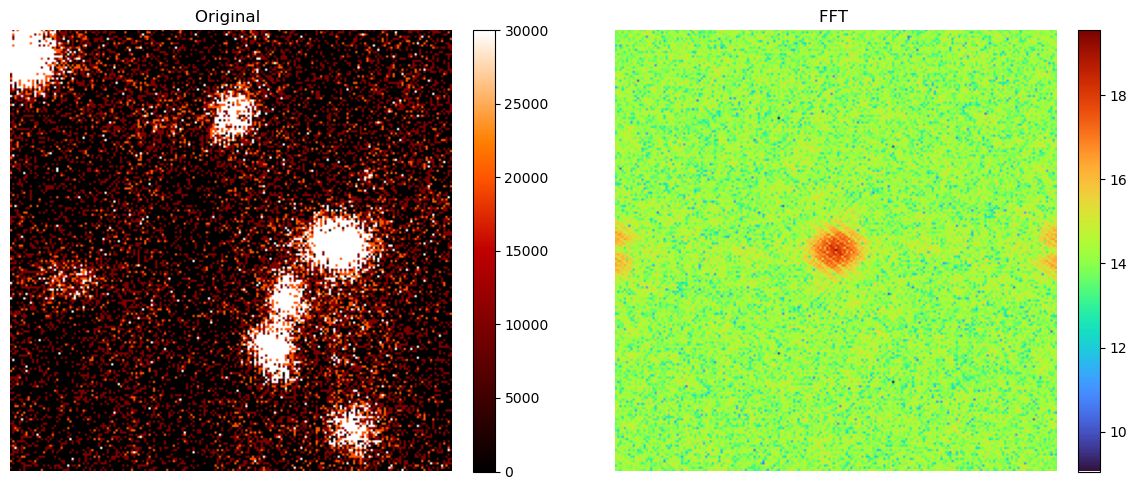

In [70]:
k = 0 
show_slice_fft(k)


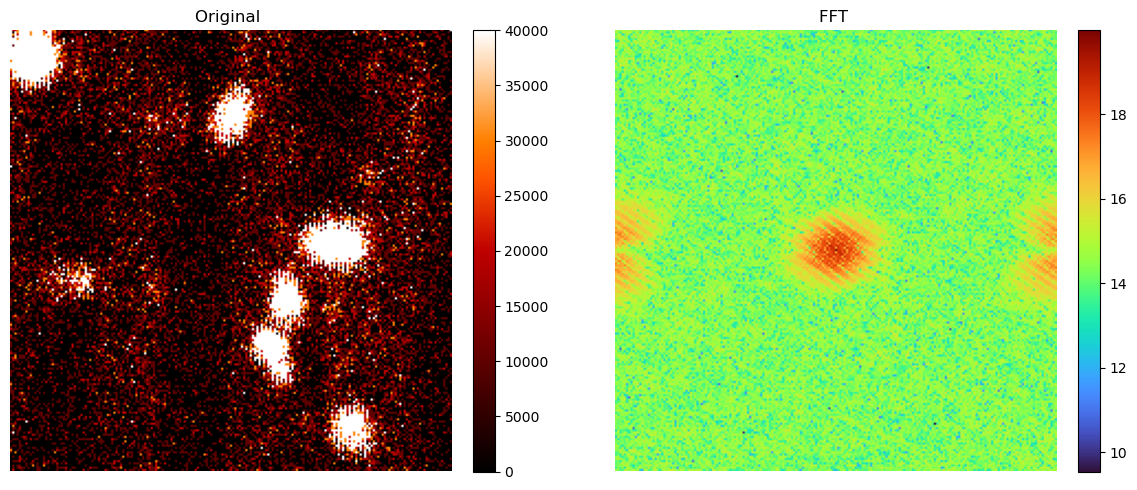

In [71]:
k = 10 
show_slice_fft(k)


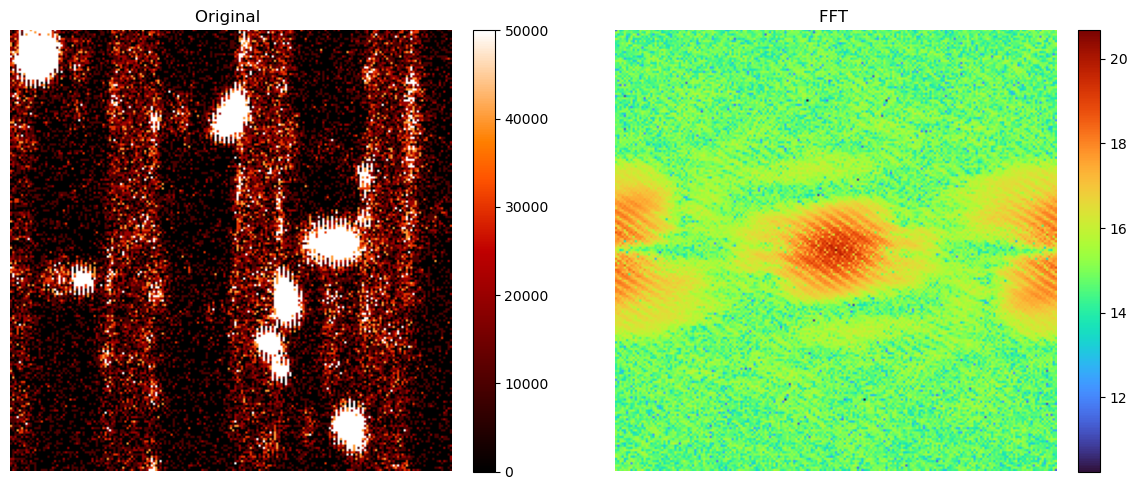

In [72]:
k = 20 
show_slice_fft(k)


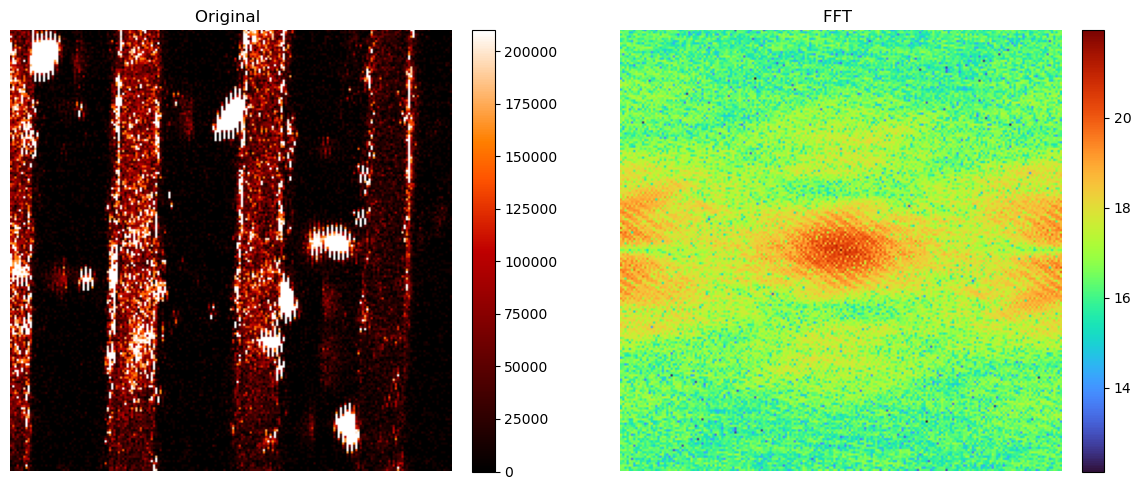

In [73]:
k = 30
show_slice_fft(k)


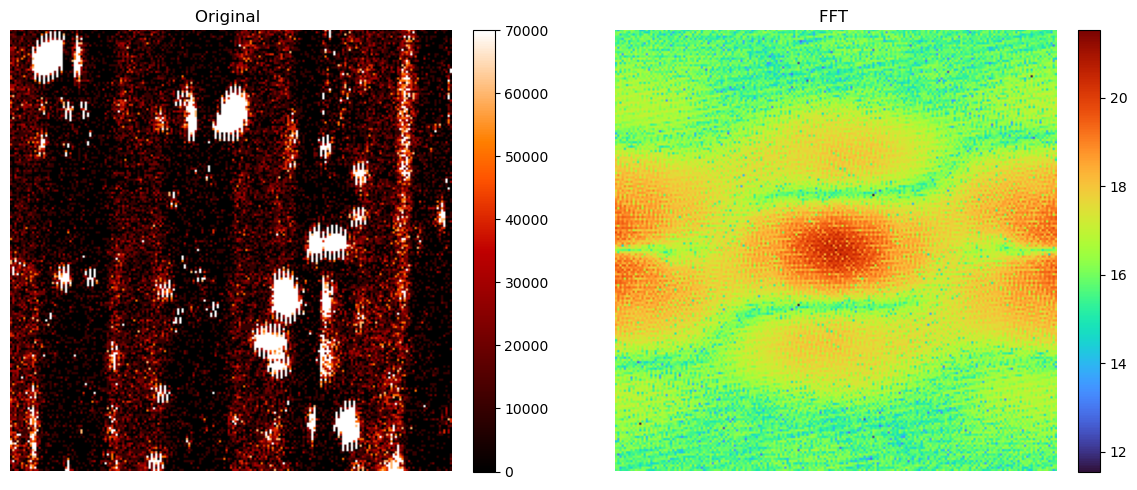

In [74]:
k = 40 
show_slice_fft(k)


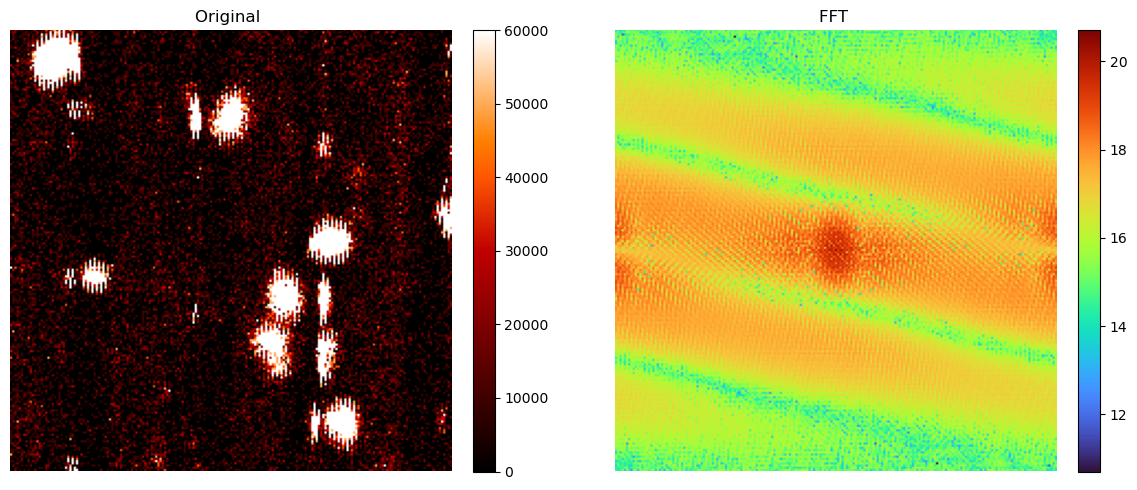

In [75]:
k = 50 
show_slice_fft(k)


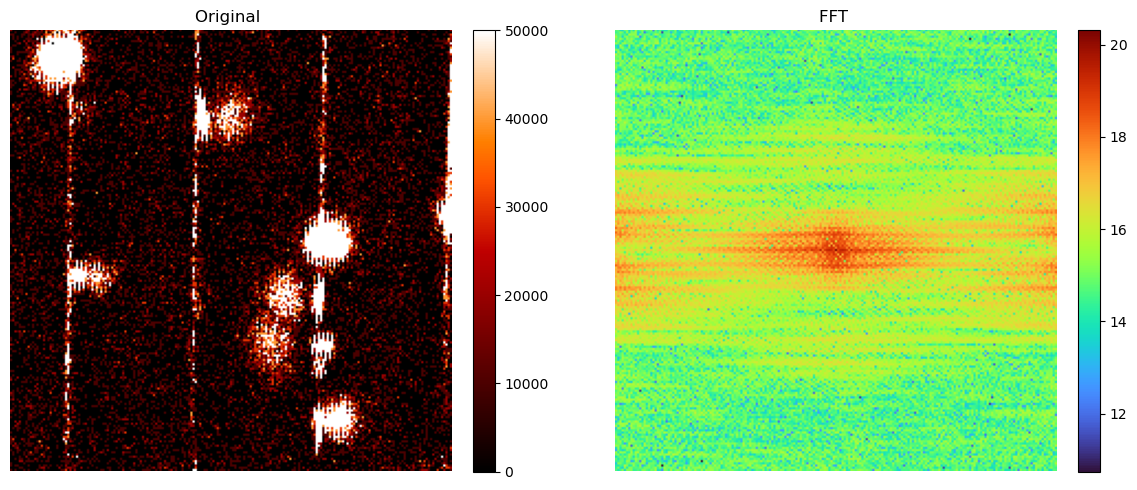

In [76]:
k = 60 
show_slice_fft(k)


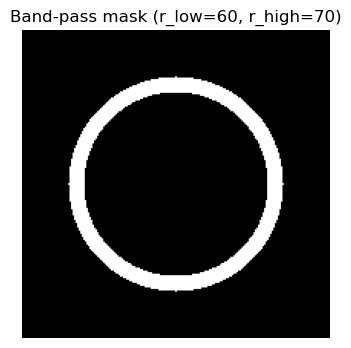

In [80]:
# สร้าง band-pass mask สำหรับโดเมนความถี่
def make_bandpass_mask(shape, r_low, r_high):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2   # จุดกึ่งกลาง (หลัง fftshift แล้ว)

    y, x = np.ogrid[:ny, :nx]
    dist = np.sqrt((y - cy)**2 + (x - cx)**2)

    # เอาเฉพาะระยะที่อยู่ระหว่าง r_low กับ r_high
    mask = (dist >= r_low) & (dist <= r_high)
    return mask.astype(float)

# กำหนดรัศมีที่ต้องการ (ลองปรับเล่นได้)
r_low  =  60
r_high = 70

mask2d = make_bandpass_mask((ny, nx), r_low, r_high)

plt.figure(figsize=(4,4))
plt.imshow(mask2d, cmap="gray", origin="lower")
plt.title(f"Band-pass mask (r_low={r_low}, r_high={r_high})")
plt.axis("off")
plt.show()


In [81]:
# ขยาย mask เป็น 3D เพื่อใช้กับทุก slice
mask3d = mask2d[:, :, None]   # shape: (ny, nx, 1)

# ใช้ mask กับ FFT volume
fft_filtered = fft_vol * mask3d

# ย้อนกลับมาที่ spatial domain (ภาพจริง)
ifft_shifted = np.fft.ifftshift(fft_filtered, axes=(0, 1))
vol_filtered_complex = np.fft.ifft2(ifft_shifted, axes=(0, 1))

# เอาเฉพาะส่วนจริง
vol_filtered = np.real(vol_filtered_complex)

print('filtered volume shape =', vol_filtered.shape)

filtered volume shape = (201, 201, 61)


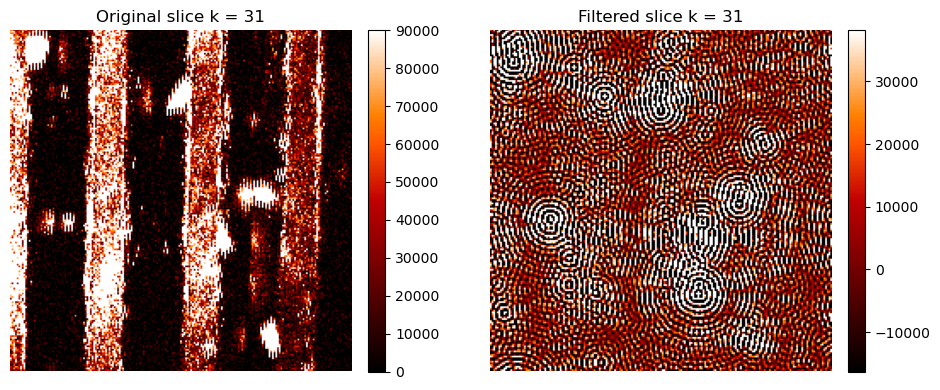

In [82]:
def show_filtered_slice(k, low_p=31, high_p=85):
    """
    low_p: เปอร์เซ็นไทล์ต่ำสุดที่จะแสดง (ตัดส่วนมืดเกินไปทิ้ง)
    high_p: เปอร์เซ็นไทล์สูงสุดที่จะแสดง (ตัดส่วนสว่างเวอร์ทิ้ง)
    """
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- ภาพต้นฉบับ ---
    # ปรับความสว่างต้นฉบับด้วย (เผื่อต้นฉบับก็ดูยาก)
    data_orig = vol[:, :, k]
    vmin0, vmax0 = np.percentile(data_orig, (low_p, high_p))
    
    im0 = axes[0].imshow(data_orig, cmap="gist_heat", origin="lower", vmin=vmin0, vmax=vmax0)
    axes[0].set_title(f"Original slice k = {k}")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # --- ภาพหลังฟิลเตอร์ ---
    data_filt = vol_filtered[:, :, k]
    
    # คำนวณช่วง vmin, vmax จากข้อมูลจริง ตัดหัวท้าย 1% เพื่อดึง Contrast
    vmin1, vmax1 = np.percentile(data_filt, (low_p, high_p))

    # แสดงผลโดยกำหนดขอบเขต vmin, vmax
    im1 = axes[1].imshow(data_filt, cmap="gist_heat", origin="lower", vmin=vmin1, vmax=vmax1)
    axes[1].set_title(f"Filtered slice k = {k}")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# เรียกใช้งาน (ลองปรับค่า k ดูครับ)
show_filtered_slice(31)